# Rheological analysis of castor oil emulsion shear viscosity mastercurve
 
This notebook performs a rheological analysis of cast oil emulsions at various concentrations, using logarithmic transformations, shift factors, master curve construction, and rheological modeling. The data is from . I. Dekker, M. Dinkgreve, H. D. Cagny, D. J. Koeze, B. P. Tighe and D. Bonn, Journal of Non-Newtonian Fluid Mechanics, 2018, 261, 33–37 and obtained from R. Lennon, G. H. McKinley and J. W. Swan, Data-Centric Engineering, 2023, 4, e13.

We import:
- `pandas` for reading and manipulating data.
- `numpy` for mathematical computations like logarithmic transformations.
- `matplotlib.pyplot` for detailed visualizations.
- `re` for regex operations to extract concentration information from filenames.
- `mastercurves` and `pyRheo` for master curve construction and model fitting.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mastercurves import MasterCurve
from mastercurves.transforms import Multiply
from pyRheo.rotation_model import RotationModel


# Load and process emulsion data
This cell loads experimental data from a CSV file containing:
- Shear rate (`gamma_dot`) in [1/s].
- Viscosity (`eta`) in [Pa·s].
The data is loaded using `pandas` and the first few rows are displayed for verification.

1. Data files for different concentrations are read.
2. Shear rate and stress data are logarithmically transformed for analysis.
3. Viscosity is calculated as the difference between the logarithmic stress and shear rate.
4. Concentration values are extracted from filenames using regex.
5. Log-transformed data is stored in separate lists for further analysis.


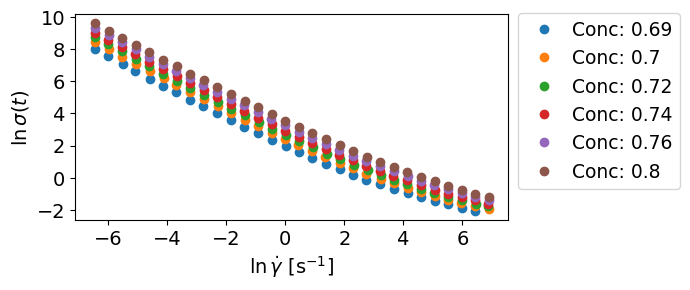

In [9]:
# List of files containing emulsion data at various concentrations
filenames = [
    './data/emulsion/0.69.csv',
    './data/emulsion/0.70.csv',
    './data/emulsion/0.72.csv',
    './data/emulsion/0.74.csv',
    './data/emulsion/0.76.csv',
    './data/emulsion/0.80.csv'
]

# Define column names and initialize lists for storing data
columns = ['Shear Rate', 'Stress']
shear_rate_list, stress_log_list, viscosity_log_list, conc_list = [], [], [], []

# Initialize figure for visualization
plt.figure(figsize=(7, 3))

# Loop through files to process data
for filename in filenames:
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep=',')
    data.columns = columns
    
    # Log-transform shear rate and stress
    log_interval_shear_rate = np.log(data['Shear Rate'])
    log_stress = np.log(data['Stress'])

    # Calculate viscosity and append to lists
    shear_rate_list.append(np.array(log_interval_shear_rate))
    stress_log_list.append(np.array(log_stress))
    viscosity_log_list.append(np.array(log_stress - log_interval_shear_rate))

    # Extract concentration from filename
    match = re.search(r'(\d+\.\d+)\.csv$', filename)
    if match:
        conc = float(match.group(1))
        conc_list.append(conc)
        plt.plot(log_interval_shear_rate, log_stress - log_interval_shear_rate, 'o', label=f'Conc: {conc}')
    else:
        print(f"Warning: No concentration found in filename {filename}")

# Finalize the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\ln \dot{\gamma}$ [s$^{-1}$]', fontsize=14)
plt.ylabel(r'$\ln \sigma(t)$', fontsize=14)
plt.legend(fontsize=13.5, handletextpad=0.5, ncol=1, bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.show()


# Construct master curve
1. Use the `MasterCurve` class to build a master curve for the emulsion data.
2. Horizontal and vertical transformations are applied using logarithmic scaling.
3. Superposition is performed to align the datasets.
4. The shift factors for aligning the data are extracted.


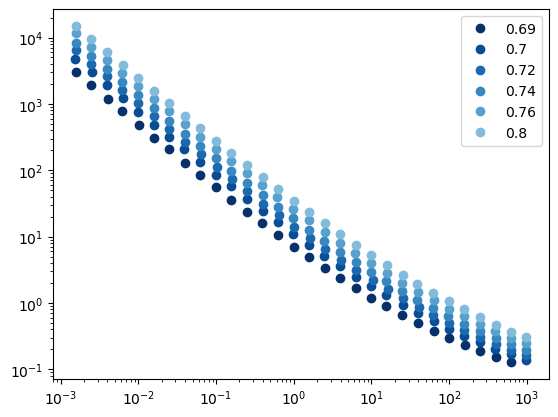

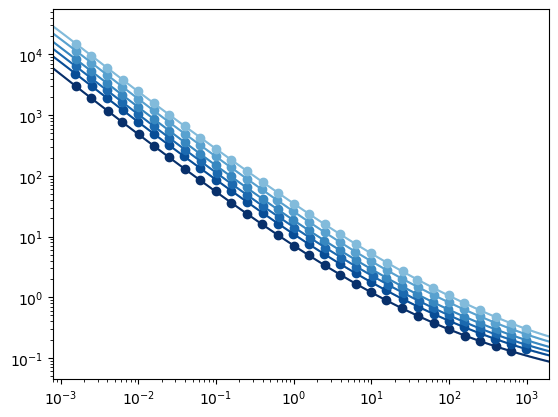

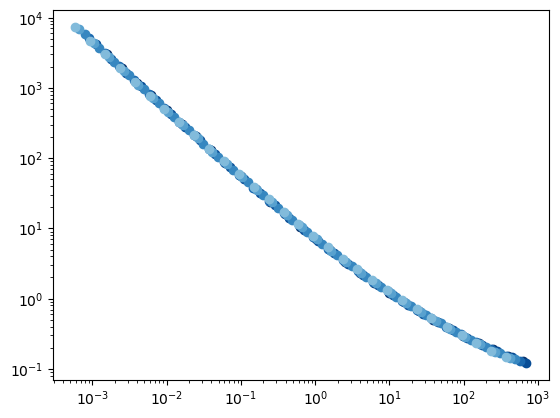

In [3]:
# Build a master curve using the MasterCurve library
mc = MasterCurve()
mc.add_data(shear_rate_list, viscosity_log_list, conc_list)

# Adjust GPR kernel
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
kernel = (ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e6)) * RBF(length_scale=[1], length_scale_bounds=(1e-10, 1e3)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e1)))
mc.set_gp_kernel(kernel)


# Apply logarithmic transformations for horizontal and vertical shifts
mc.add_htransform(Multiply(scale="log")) # natural log
mc.add_vtransform(Multiply(scale="log")) # natural log

# Perform superposition
mc.superpose()

# Plot the master curve and extract shift factors
fig1, ax1, fig2, ax2, fig3, ax3 = mc.plot(colormap=lambda i: plt.cm.Blues_r(i / 1.5))
hshift_factors = [np.array(np.log(factor)) for factor in mc.hparams[0]]
vshift_factors = [np.array(np.log(factor)) for factor in mc.vparams[0]]


# Plot shift factors as a function of temperature


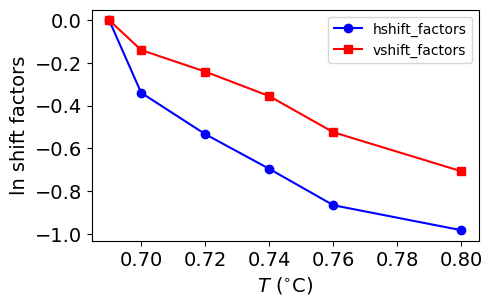

In [4]:
# Create the plot
plt.figure(figsize=(5, 3))

# Plot both factors
plt.plot(conc_list, hshift_factors, label="hshift_factors", marker='o', color='blue')
plt.plot(conc_list, vshift_factors, label="vshift_factors", marker='s', color='red')

# Add labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$T$ ($^{\circ}$C)', fontsize=14)
plt.ylabel('ln shift factors', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Apply shift factors to data
1. Shift factors are used to align all datasets onto a single master curve.
2. Log-transformed data is shifted and converted back to the original scale.
3. The combined shear rate and viscosity values are stored for further analysis.


In [5]:
shifted_shear_rate, shifted_viscosity = [], []

for idx, (shear_rate_log, viscosity_log) in enumerate(zip(shear_rate_list, viscosity_log_list)):
    # Apply shift factors
    shifted_shear_rate_log = shear_rate_log + hshift_factors[idx]
    shifted_viscosity_log = viscosity_log + vshift_factors[idx]

    # Convert back to linear scale and append
    shifted_shear_rate = np.concatenate([shifted_shear_rate, np.exp(shifted_shear_rate_log)])    
    shifted_viscosity = np.concatenate([shifted_viscosity, np.exp(shifted_viscosity_log)])

# Organize and visualize shifted data
1. Create a DataFrame from the shifted shear rate and viscosity arrays.
2. Clean the data by removing NaN values.
3. Reorder the DataFrame by shear rate for consistent visualization.
4. Plot the shifted data to validate the alignment from the master curve transformation.


   Shear Rate    Viscosity
0    0.000592  7380.218037
1    0.000661  6818.398370
2    0.000793  5796.384334
3    0.000914  5070.403684
4    0.000933  4684.669963


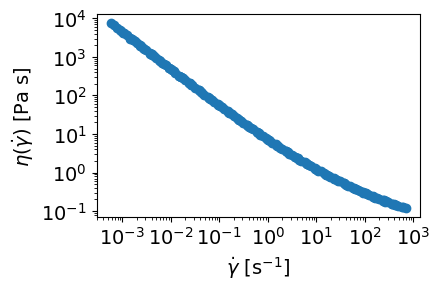

In [6]:
# Create a DataFrame from shifted shear rate and viscosity arrays
df = pd.DataFrame({'Shear Rate': shifted_shear_rate, 'Viscosity': shifted_viscosity})

# Clean NaNs
df_cleaned = df.dropna()

# Reorder the DataFrame by 'Shear Rate' from minimum to maximum
df_sorted = df_cleaned.sort_values(by='Shear Rate', ascending=True).reset_index(drop=True)

# Show the DataFrame (optional)
print(df_sorted.head())

# Plot
plt.figure(figsize=(4.5, 3))
plt.plot(shifted_shear_rate, shifted_viscosity, "o")

# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\dot{\gamma}$ [s$^{-1}$]', fontsize=14)
plt.ylabel(r'$\eta(\dot{\gamma})$ [Pa s]', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


# Fit model to master curve with pyRheo
1. The master curve data (shear rate and viscosity) is used for model fitting.
2. The `pyRheo` library is employed to fit a Herschel-Bulkley model.
3. The model parameters, fitting error, and predictions are displayed.


Best initial guess was: [49311.17608692456, 47827.61440807474, 0.7194383172087958]
sigma_y: 4.622043112441408
k: 2.371102728606842
n: 0.5168671112791493
RSS: 0.19615758552615917
Mean Percentage Error: 2.59%


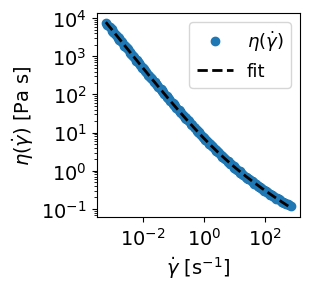

In [7]:
# Load master curve data
shear_rate_mc = df_sorted['Shear Rate'].values
viscosity_mc = df_sorted['Viscosity'].values

# Model fitting
model = RotationModel(model="HerschelBulkley", initial_guesses="random", num_initial_guesses=64, minimization_algorithm="Powell")
model.fit(shear_rate_mc, viscosity_mc)

model.print_parameters()
model.print_error()
model.plot(shear_rate_mc, viscosity_mc, savefig=False)

# Plot the master curve with colors and fitted prediction
1. Use the previously calculated horizontal (`hshift_factors`) and vertical (`vshift_factors`) shift factors to align data from multiple datasets.
2. Load the datasets and apply transformations to shear rate and viscosity using the shift factors.
3. Generate a color-coded plot for each dataset showing the aligned data.
4. Overlay the master curve prediction from the fitted model for comparison.
5. Customize the plot with labels, scales, and legends, and save the final visualization.


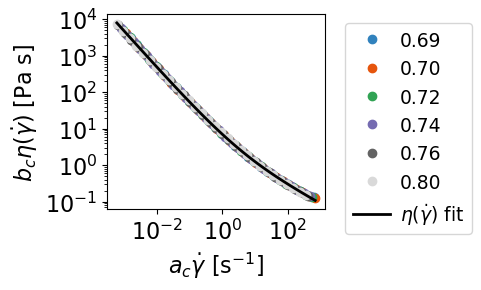

In [8]:
# Import packages for plotting
import matplotlib as mpl
from matplotlib.ticker import LogLocator

# Plot master curve labeled with the model prediction
gamma_dot_predict = np.logspace(np.min(np.log10(shear_rate_mc)), np.max(np.log10(shear_rate_mc)), 100)
viscosity_predict = model.predict(gamma_dot_predict)

# List of files to process
sorted_filenames = [
    './data/emulsion/0.69.csv',
    './data/emulsion/0.70.csv',
    './data/emulsion/0.72.csv',
    './data/emulsion/0.74.csv',
    './data/emulsion/0.76.csv',
    './data/emulsion/0.80.csv'
]


num_files = len(sorted_filenames)

# Adjusted size for better visibility of multiple plots
plt.figure(figsize=(5, 3))

# Reordered labels based on concentrations (lowest concentration first)
labels = [
    "0.69", "0.70", "0.72", "0.74",
    "0.76", "0.80"
]

# Get the colormap (this returns a continuous colormap)
colormap = mpl.colormaps['tab20c']

# Convert it to a discrete colormap with 'num_files' colors
colors = colormap(np.linspace(0, 1, num_files))

# Store legend handles for different concentrations
temp_handles = []

# Plot data
for i, filename in enumerate(sorted_filenames):
    # Load the data from the CSV file
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep=',')
    data.columns = columns

    # Extract and log-transform the 'Shear Rate' and 'Stress' columns
    log_interval_shear_rate = np.log(data['Shear Rate'])
    log_stress = np.log(data['Stress'])
    log_viscosity = log_stress - log_interval_shear_rate

    # Apply shift factor
    log_interval_shear_rate_shifted = log_interval_shear_rate + hshift_factors[i]
    log_interval_viscosity_shifted = log_viscosity + vshift_factors[i]

    # Get label and color
    label = labels[i]
    color = colors[i % len(colors)]

    # Plot viscosity data with shifts applied
    plt.plot(np.exp(log_interval_shear_rate_shifted), np.exp(log_interval_viscosity_shifted), 'o', 
             color=color, markersize=6, alpha=1, label=label)
    
# Plot master curve fit
plt.plot(gamma_dot_predict, viscosity_predict, '-', color="k", lw=2, label='$\eta(\dot{\gamma})$ fit')

# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$a_{c}\dot{\gamma}$ [s$^{-1}$]', fontsize=16)
plt.ylabel(r'$b_{c}\eta(\dot{\gamma})$ [Pa s]', fontsize=16)
plt.legend(fontsize=13.5, loc='upper left', handletextpad=0.5, bbox_to_anchor=(1.05, 1))
plt.grid(False)
plt.tight_layout()

# Display the plot
plt.show()
